#Кредитный дефолт (German Credit Data)

German credit data - общедоступный дата-сет, в котором представлена некоторая информация о заемщиках, а так же информация о том, вышли они в дефолт или нет. Описание и данные доступны по [ссылке](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/). У меня уже имеется csv file, в котором прописаны названия столбцов. Цель данного исследования:
* построить несколько моделей, которые будут предсказывать вероятность кредитного дефолта, и выбрать из них лучшую;
* разработать форму отчета, которая будет характеризовать стабильность популяции. Т.е. показывать насколько текущий поток кредитных заявок (новых заявок) отличается от базового (того, на котором построена модель). Это необходимо для того, чтобы вовремя увидеть новые тренды и оттюнить модель.
Анализировать данные я буду в [pandas](http://pandas.pydata.org/), а модели строить с помощью [scikit-learn](http://scikit-learn.org/stable/).

Для начала загрузим дата-сет.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1) # зафиксим рандом
df = pd.read_csv('germancredit.csv')
df.columns

Index([u'Default', u'checkingstatus1', u'duration', u'history', u'purpose',
       u'amount', u'savings', u'employ', u'installment', u'status', u'others',
       u'residence', u'property', u'age', u'otherplans', u'housing', u'cards',
       u'job', u'liable', u'tele', u'foreign'],
      dtype='object')

Проверим на наличие NA.

In [2]:
df.isnull().values.any()

False

Какой хорший дата-сет, ни одной пропущенной переменной. К сожалению в жизни так не бывает).

Теперь создадим **y** и **X** для тренировки моделей: **y** (кредитный дефолт) - то, что будем предсказывать, **X** (все остальные переменые) - по чему будем предсказывать. Из качественных переменных необходимо создать **dummy переменные**. Обратиче внимание, что для каждой переменной будет создано n-1 столбцов, где n - кол-во категорий в каждой переменной (действительно - если в каждой категории 0, то это значит, что строчка побадет в ту невошедшую категорию). Для этого будем использовать dmatrices из библиотеки [patsy](https://patsy.readthedocs.org/en/latest/).

In [3]:
df.dtypes

Default             int64
checkingstatus1    object
duration            int64
history            object
purpose            object
amount              int64
savings            object
employ             object
installment         int64
status             object
others             object
residence           int64
property           object
age                 int64
otherplans         object
housing            object
cards               int64
job                object
liable              int64
tele               object
foreign            object
dtype: object

In [4]:
from patsy import dmatrices
from sklearn.cross_validation import train_test_split

# сначала загоним в модели все переменные 
formula = ''
for column in df.columns[1:]:
    if df[column].dtype == 'int64':
        formula += column + '+'
    else:
        # если переменная качественная, то по ситнаксису dmatrices
        # добавляем C (от category)
        formula += 'C(' + column + ')+'
formula = df.columns[0] + '~' + formula[:-1]

def test_train(formula, df):
    y,X = dmatrices(formula,df, return_type="dataframe")
    y = pd.np.ravel(y) # перобразуем y в одномерный массив
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    return y, X, X_train, X_test, y_train, y_test

y, X, X_train, X_test, y_train, y_test = test_train(formula, df)

Создадим список с моделями, которые будем тестировать и потренируем их.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
models = []
models.append(LogisticRegression())
models.append(RandomForestClassifier(n_estimators=100, criterion='entropy'))
for model in models:
    model.fit(X_train, y_train)

Далее выведем [кривые-ошибок](https://ru.wikipedia.org/wiki/ROC-кривая).

In [6]:
from sklearn.metrics import roc_curve
import ml_metrics
import matplotlib.pyplot as plt
%matplotlib inline

def roc_comparison(models, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(10, 10)) 
    for model in models:
        pred_scr = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred_scr)
        roc_auc = ml_metrics.auc(y_test, pred_scr)
        md = str(model)
        md = md[:md.find('(')]
        plt.plot(fpr, tpr, label='ROC fold %s (auc = %0.2f)' % (md, roc_auc))
        

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

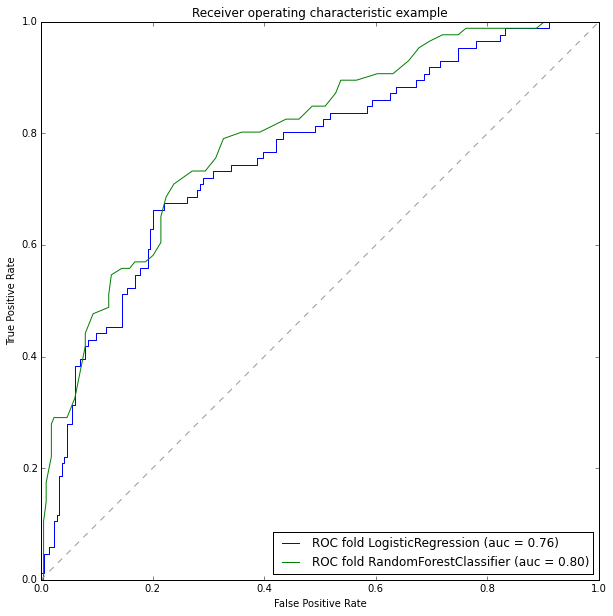

In [7]:
roc_comparison(models, X_train, X_test, y_train, y_test)

Случайный лес показал себя лучше. Теперь предлагаю проанализировать данные и посмотреть, как разные показатели влияют на дефолт.

Сделаю функцию, которая будет выводить 100% stacked bar chart, чтобы увидеть тенденции.

In [8]:
def stack_hundred(column):
    test = df.groupby([column,'Default'])['Default'].count().unstack()
    print df.groupby(['Default',column])['Default'].count().unstack()
    test.div(test.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True).plot(kind='bar',stacked=True)

checkingstatus1  A11  A12  A13  A14
Default                            
0                139  164   49  348
1                135  105   14   46


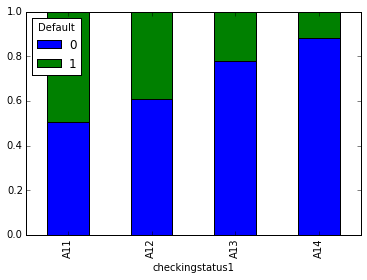

In [9]:
stack_hundred('checkingstatus1')

Наличие сберегательного счета положительно влияет на платеже способность заемщика.

history  A30  A31  A32  A33  A34
Default                         
0         15   21  361   60  243
1         25   28  169   28   50


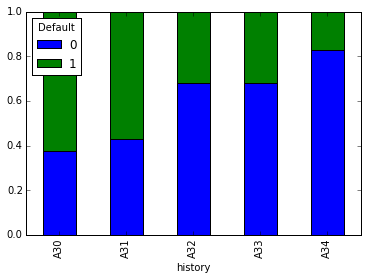

In [10]:
stack_hundred('history')

A31 : all credits at this bank paid back duly Не очень вероятно, что клиенты исправно заплатившие за кредиты в прошлом будут хуже платить в будщем.

A33 : delay in paying off in the past. Не может быть, чтобы заемщики имеющие просрочку в прошлом лучше платили по новым кредитам.

Наверное в данном случае информацию о кредитной истории можно не использовать, но в реальной жизне эта информация очень важная.

purpose  A40  A41  A410  A42  A43  A44  A45  A46  A48  A49
Default                                                   
0        145   86     7  123  218    8   14   28    8   63
1         89   17     5   58   62    4    8   22    1   34


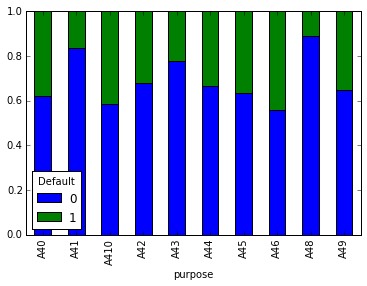

In [11]:
stack_hundred('purpose')

Здесь мы видим, что хорошими предикторами являются цели на машины, на бытовую технику и на мебель и на бизнес (наверное на стартапы). Думаю, что цель кредита можно оставить в моделе полностью. Можно перегруппировать переменную и оставить три категории: машина, дом, все остальные. Сразу это и сделаем.

In [12]:
group_dict = {'A40':'car', 'A41':'car', 'A42':'home', 
              'A43':'home', 'A44':'home', 'A45':'home',
              'A46':'other', 'A48':'other', 'A49':'other','A410':'other'}
df['purpose1'] = df['purpose']
df.replace({'purpose1':group_dict}, inplace=True)

purpose1  car  home  other
Default                   
0         231   363    106
1         106   132     62


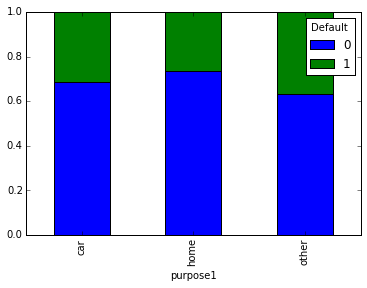

In [13]:
stack_hundred('purpose1')

Теперь гораздо проще и понятнее.

savings  A61  A62  A63  A64  A65
Default                         
0        386   69   52   42  151
1        217   34   11    6   32


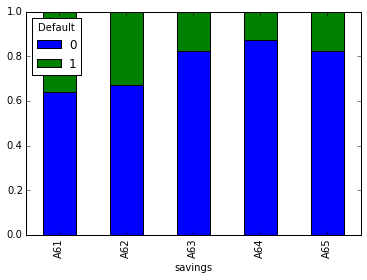

In [14]:
stack_hundred('savings')

Размер сбережений тоже работает.

employ   A71  A72  A73  A74  A75
Default                         
0         39  102  235  135  189
1         23   70  104   39   64


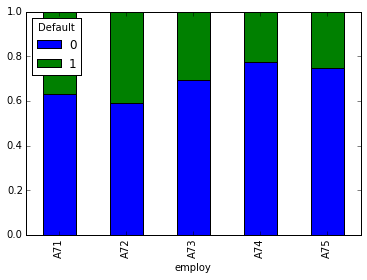

In [15]:
stack_hundred('employ')

Все логично.

status   A91  A92  A93  A94
Default                    
0         30  201  402   67
1         20  109  146   25


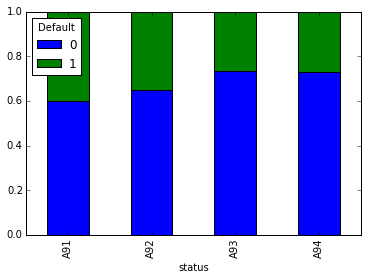

In [16]:
stack_hundred('status')

По опыту знаю, что в России женщины платят лучше чем мужчины, и просто пол является хорошим предиктором. Здесь же одинокий мужчина платит лучше, чем замужняя женщина (A93 и A92). Но это немецкие данные, и я предлагаю не лезьть в немецкий менталитен и положиться на логику в этом дата-сете. Что русскому хорошо, то немцу сами знаете). В данном случае я решаю не использовать эту переменную. 

others   A101  A102  A103
Default                  
0         635    23    42
1         272    18    10


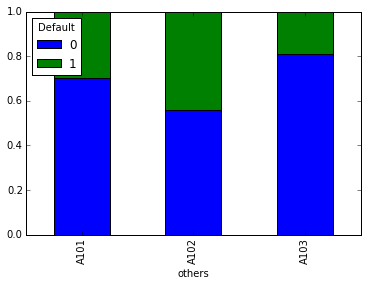

In [17]:
stack_hundred('others')

Не логично выглядит A102 - наличие co-aplicants. Я думаю, что если люди подают заявку вдвоем (например муж и жена), то такие заемщики надежней. Не буду использовать эту переменную.

property  A121  A122  A123  A124
Default                         
0          222   161   230    87
1           60    71   102    67


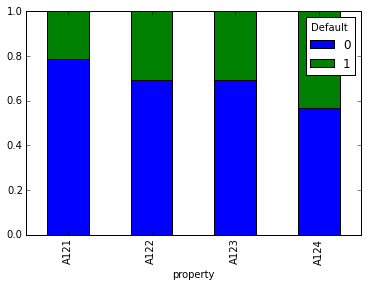

In [18]:
stack_hundred('property')

Здесь все на мой взгляд логично - если есть квартира - заплатит хорошо.

otherplans  A141  A142  A143
Default                     
0             82    28   590
1             57    19   224


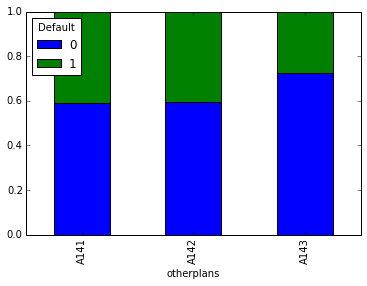

In [19]:
stack_hundred('otherplans')

Тут тоже все ок - если не платит где-нибудь в другом месте, то вероятность дефолта меньше.

housing  A151  A152  A153
Default                  
0         109   527    64
1          70   186    44


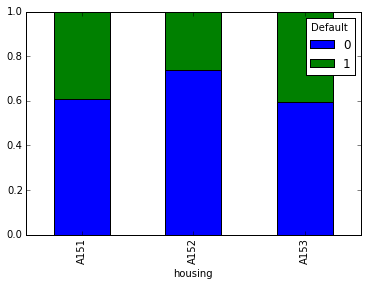

In [20]:
stack_hundred('housing')

Тоже нету вопросов - если квартива в собственности, то заемщик хороший. Но возможно предиктор property - более важный. И в какой-то степени исключает данный. Но наверное информация о жилищных условиях, тоже важна - если человек ничего не имеет и не платит за аренду, то в моей модели у него меньше шансев. Но все же можно и без нее попробовать.

job      A171  A172  A173  A174
Default                        
0          15   144   444    97
1           7    56   186    51


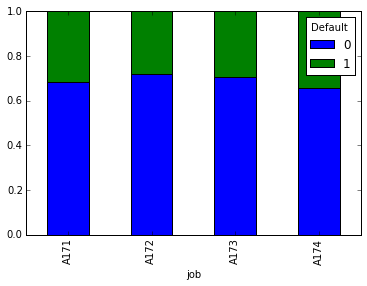

In [21]:
stack_hundred('job')

Чем лучше работа - чем хуже платит? Не верю. Дело в том, что заемщики не склонны указывать, что у них плохая квалификация. Не буду использовать эту переменную.

tele     A191  A192
Default            
0         409   291
1         187   113


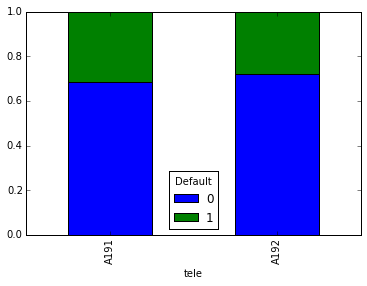

In [22]:
stack_hundred('tele')

Те у кого есть телефон платят лучше). 

foreign  A201  A202
Default            
0         667    33
1         296     4


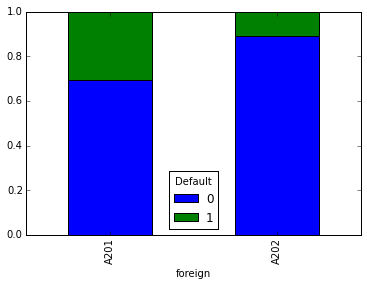

In [23]:
stack_hundred('foreign')

Найтив работик платит лучше, это очевидно.)

Теперь взглянем на количиственные данные.

In [24]:
df.groupby('Default').mean()

,duration,amount,installment,residence,age,cards,liable
Default,,,,,,,
0,19.207143,2985.457143,2.920000,2.842857,36.224286,1.424286,1.155714
1,24.860000,3938.126667,3.096667,2.850000,33.963333,1.366667,1.153333


Здесь все более менее нормально:
* чем дольше срок кредита - тем больше вероятность, что с заёмщиком что-то случиться и от перестанет плататить.
* чем больше сумма кредита, тем сложнее его вернуть.
* чем выще отношение аннуитета к ежемесячному заработку, тем хуже
* residense особо не влияет
* тем старше заемщик - тем лучше. Совком тому пример)
* чем больше на человеке кредитов, тем хуже
* наличие рекомендателей в данном случае не сыграло.

Изменим формулу для создания тестовых и тренировочных сетов, обучим модели заново и сравним с первыми.

In [25]:
formula2 = 'Default~C(checkingstatus1)+duration+C(purpose1)+\
amount+C(savings)+C(employ)+installment+\
C(property)+age+C(otherplans)+\
C(housing)+cards+C(tele)+C(foreign)'

In [26]:
y1, X1, X_train1, X_test1, y_train1, y_test1 = test_train(formula2, df)

In [27]:
models2 = []
models2.append(LogisticRegression())
models2.append(RandomForestClassifier(n_estimators=100, criterion='entropy'))
for model in models2:
    model.fit(X_train1, y_train1)

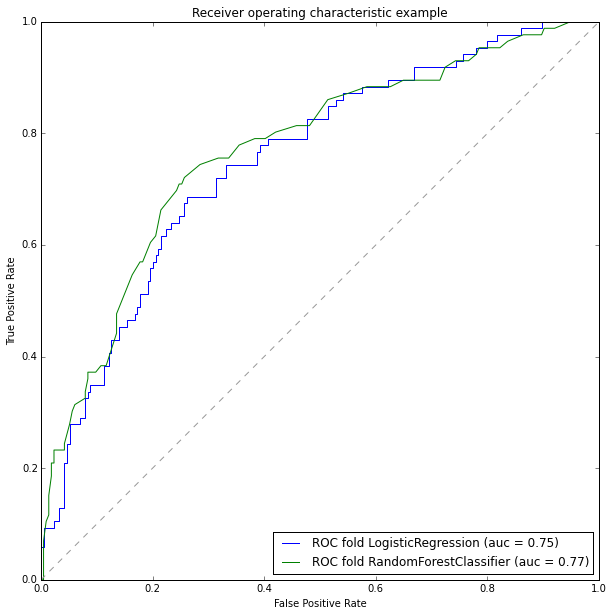

In [28]:
roc_comparison(models2, X_train1, X_test1, y_train1, y_test1)

Манипуляции с данными не улучшили показатели ROC, даже немного ухудшили. Но теперь я уверен, что в моделе все логично, а так же, что она в меньшей степени переобучена.

#Стабильность популяции

Стандартной метрикой является Индекс Стабильности Популяции (PSI). 

$$PSI=\sum ((Текущая\ \%-Базавая\ \%)\times (ln(\frac{Текущая\ \%}{Базовая\ \%})) $$

Индекс рассчитывается для распределения переменных из Базовой и Текущей популяции в процентах по каждому бакету, а потом суммируется. Увеличение индекса свидетельствует о сдвигах в Текущей популяции.

Вместе с PSI индексом нужно так же выводить диаграмму распределения Базовой и Текущей популяции, чтобы видеть сдвиги в каждом бакете и понимать что делать дальше.

Приведу пример. Возмем тестоый сет и рассчитаем для нее вероятность дефолта на основе последней регрессионной модели - будем считать эту выборку Текущей. Базовой выборкой будем считать весь сет данных, для нее тоже рассчитает дефолт. Дале посмотрим на распределение вероятностей дефолта в процентах по бакетам для Базовой и Текущей выборки, рассчитаем PSI и построим диаграмму.

In [29]:
base = pd.DataFrame(models2[0].predict_proba(X1)[:, 1])
test = pd.DataFrame(models2[0].predict_proba(X_test1)[:, 1])
bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [30]:
def psi(test,base,bins):    
    binned = base.groupby(pd.cut(base[0],bins)).count()
    binned[0] = binned[0]/binned[0].sum()
    binned[1] = test.groupby(pd.cut(test[0],bins)).count()
    binned[1] = binned[1]/binned[1].sum()
    binned.columns = ['base','test']
    binned['test - base'] = binned['test']-binned['base']
    binned['test/base'] = binned['test']/binned['base']
    binned['psi'] = binned['test - base'] * np.log(binned['test/base'])
    return binned

In [31]:
def report(test,base,bins):
    df = psi(test,base,bins)
    print df['psi']
    df[['base','test']].plot(kind='bar')
    print 'Population Stability Index = ', df['psi'].sum()

0
(0.1, 0.2]    0.001426
(0.2, 0.3]    0.002460
(0.3, 0.4]    0.000017
(0.4, 0.5]    0.013763
(0.5, 0.6]    0.006541
(0.6, 0.7]    0.000428
(0.7, 0.8]    0.001005
(0.8, 0.9]    0.000143
(0.9, 1]           inf
Name: psi, dtype: float64
Population Stability Index =  inf


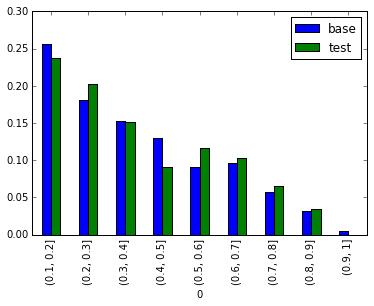

In [32]:
report(test,base,bins)

Теперь вместо тестового сета возьмем часть исходного сета с заданным параметром.

In [33]:
test1 = pd.DataFrame(models2[0].predict_proba(X1[X1['C(savings)[T.A62]'] == 1])[:, 1])

0
(0.1, 0.2]    0.010382
(0.2, 0.3]    0.000050
(0.3, 0.4]    0.004869
(0.4, 0.5]    0.037811
(0.5, 0.6]    0.029618
(0.6, 0.7]    0.007859
(0.7, 0.8]    0.008203
(0.8, 0.9]    0.014504
(0.9, 1]           inf
Name: psi, dtype: float64
Population Stability Index =  inf


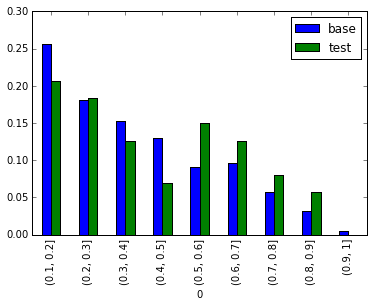

In [34]:
report(test1,base,bins)

Индекс стабильности популяции сильно вырос. Это говорит нам о том, что в данных что-то изменилось. В данном случае я взял только тех людей, чьи сбережения находятся в диапазоне [100;500). Очевидно, что такая выборка будет отличаться от всего дата-сета. Индекс стабильно популяции нам на это и указывает.

После того, как стало ясно, что что-то изменилось - нужно понять что. Для этого можно построить диаграммы распределения каждой переменной (как я делал в анализе данных) и сравнить с исходными. Сразу станет ясно где произошел перекос.